In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Application to CTA Data and Boosting


<h2 id="tocheading">Table of Contents</h2>
<div id="toc"></div>


The story so far:

- Linear Discriminant Analysis (LDA) and Fisher's linear discriminant
- Principal Component Analysis (PCA)
- Feature Selection
- Supervised Learning
- Clustering

In [2]:
from ml import plots
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap

In [3]:
pd.options.display.max_rows = 10
plots.set_plot_style()

In [4]:
%matplotlib inline

# A Complete Example

Below we load a dataset containing data from simulated CTA Observations.

<img width="100%" src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/CTA_Telescopes_in_Southern_Hemisphere.jpg/1280px-CTA_Telescopes_in_Southern_Hemisphere.jpg" />   

We will perform the typical steps to build and evaluate a classifier.

0. Understand where your data comes from

1. Preprocessing
    * Drop Constant Values,
    * Handle Missing Data 
    * Feature Generation

2. Splitting
    
    * Split your data into training and evaluation sets
    
3. Training 
    
    * Train your classifier of choice.
    
4. Evaluation
    
    * Evaluate the performance on the test data set.
    * If not good enough, go back to step 1 
    
5. Physics
    
    * Check whether your data support your hypothesis
    

## 1. Get to know your data

Cherenkov telescopes record short flashes of light produced by very high energy cosmic rays and photons hitting earths atmosphere.

![](https://www.cta-observatory.org/wp-content/uploads/2016/05/cta47.png)

In [5]:
%%HTML
<!-- https://nextcloud.e5.physik.tu-dortmund.de/index.php/s/e7yb2mifGDeyDBN/download -->
<video width="100%" controls>
  <source src="./resources/lstsubarray_stereo.mp4" type="video/mp4">
</video>

We will use machine learning for two tasks in this example. 

 * Train a classifier to distinguish events induced by gamma rays form events induced by cosmic rays
 * Train a regressor to estimate the energy of the incoming primary particle.

## 2. Preprocess data

A _**lot**_ of preprocessing has _already_ happened at this point.

* Calibration of Raw Data
* Data Reduction from voltage timeseries per pixel to number of photons and mean time for each pixel
* Calculation of image features
* Geometrical Reconstruction of the Shower Geometry


Load data and remove unwanted columns and store the true labels separately.

In [6]:
import pandas as pd
from ctapipe.io import TableLoader
from ctapipe.utils import get_dataset_path

The dataset here is very similar but much smaller than the full dataset released publicly here:
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7298569.svg)](https://doi.org/10.5281/zenodo.7298569)

In [7]:
gamma_path = get_dataset_path('gamma_diffuse_dl2_train_small.dl2.h5')
proton_path = get_dataset_path('proton_dl2_train_small.dl2.h5')

/opt/anaconda3/envs/ml/lib/python3.10/site-packages/ctapipe/instrument/subarray.py:395: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


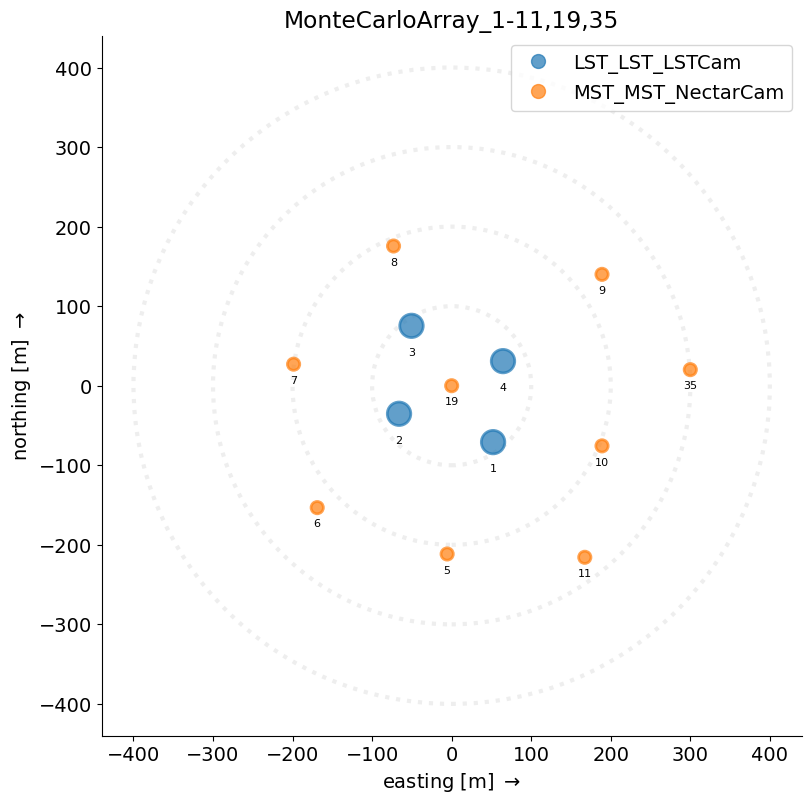

In [8]:
with TableLoader(gamma_path) as loader:
    subarray = loader.subarray

subarray.peek()

In [9]:
def read_events(path):

    loader = TableLoader(
        path,
        load_dl2=True,
        load_instrument=True,
        load_simulated=True,
    )

    table = loader.read_telescope_events()

    # these two columns are arrays in each row, which is not supported by pandas
    table.remove_columns(['tels_with_trigger', 'HillasReconstructor_telescopes'])

    # convert astropy.table.Table to pd.DataFrame
    return table.to_pandas()

In [10]:
gammas = read_events(gamma_path)

In [11]:
len(gammas.columns)

92

Now delete all simulated values which can not be observed during measurement in the physical world. We know which columns to remove because they have a special prefix.

In [12]:
forbidden_columns = 'true_|obs_id|event_id'
gammas = gammas.filter(regex=f'^(?!{forbidden_columns}).*$')

len(gammas.columns)

80

Check the data types of the columns. We can select non-numeric types and encode them. But in this case we might as well drop them as the attribute is not important.

In [13]:
c = gammas.select_dtypes(exclude=['number', 'bool']).columns
print('Removed columns:', c.values)

gammas = gammas.drop(c, axis='columns')

Removed columns: ['time_mono' 'name' 'type' 'camera_name' 'optics_name_1' 'tel_description'
 'optics_name_2' 'size_type' 'reflector_shape' 'time']


We can spot the columns with constant values by looking at the count and/or standard deviation.

In [14]:
desc = gammas.describe()
desc

,tel_id,n_trigger_pixels,hillas_intensity,hillas_skewness,hillas_kurtosis,hillas_fov_lon,hillas_fov_lat,hillas_r,hillas_phi,hillas_length,...,HillasReconstructor_core_uncert_x,HillasReconstructor_core_uncert_y,HillasReconstructor_core_tilted_x,HillasReconstructor_core_tilted_y,HillasReconstructor_core_tilted_uncert_x,HillasReconstructor_core_tilted_uncert_y,HillasReconstructor_h_max,HillasReconstructor_h_max_uncert,HillasReconstructor_average_intensity,HillasReconstructor_goodness_of_fit
count,94572.000000,94572.000000,71529.000000,71529.000000,71529.000000,71529.000000,71529.000000,71529.000000,71529.000000,71529.000000,...,0.0,0.0,61560.000000,61560.000000,0.0,0.0,61560.000000,0.0,61560.000000,0.0
mean,9.662257,19.123483,1093.364843,0.001066,2.348637,0.015764,0.026184,2.336999,1.870793,0.265868,...,NaN,NaN,-26.174997,-74.505371,NaN,NaN,9358.529273,NaN,1387.421161,NaN
std,8.854069,33.652931,8851.418858,0.456087,0.759267,1.800013,1.787567,0.987287,103.509011,0.192408,...,NaN,NaN,648.900798,5373.040471,NaN,NaN,5956.130416,NaN,6800.237330,NaN
min,1.000000,-1.000000,50.003008,-5.572948,1.003440,-3.739235,-4.054492,0.010258,-179.981834,0.039044,...,NaN,NaN,-29790.770133,-766599.573460,NaN,NaN,129.710210,NaN,51.449854,NaN
25%,4.000000,-1.000000,96.439808,-0.259209,1.942667,-1.309211,-1.322928,1.579093,-87.313957,0.133427,...,NaN,NaN,-149.406943,-179.243183,NaN,NaN,7806.216554,NaN,173.016390,NaN
50%,7.000000,15.000000,194.843542,-0.000092,2.201602,0.016291,0.047204,2.257430,3.595442,0.197188,...,NaN,NaN,-27.739348,-32.807535,NaN,NaN,9154.440840,NaN,334.606748,NaN
75%,10.000000,22.000000,503.490359,0.263246,2.557658,1.360622,1.368379,3.249717,91.592366,0.337939,...,NaN,NaN,86.577893,112.152721,NaN,NaN,10629.336694,NaN,789.830858,NaN
max,35.000000,1694.000000,832645.208949,3.365842,33.352201,3.745594,4.064763,4.080192,179.995002,1.798619,...,NaN,NaN,54697.243833,27805.383367,NaN,NaN,731044.701452,NaN,228815.603773,NaN


In [15]:
c = desc.columns[desc.loc['std'] == 0]
print('Removed columns:', c.values)
gammas = gammas.drop(c, axis='columns')

Removed columns: ['n_mirrors' 'event_type']


drop columns where all rows are nan

In [16]:
c = gammas.columns[gammas.count() == 0]
print('Removed columns:', c.values)
gammas = gammas.drop(c, axis='columns')

Removed columns: ['HillasReconstructor_tel_impact_distance_uncert'
 'HillasReconstructor_core_uncert_x' 'HillasReconstructor_core_uncert_y'
 'HillasReconstructor_core_tilted_uncert_x'
 'HillasReconstructor_core_tilted_uncert_y'
 'HillasReconstructor_h_max_uncert' 'HillasReconstructor_goodness_of_fit']


here we do a specific pre-selection, again using "expert knowledge"

In [ ]:
print(len(gammas))
gammas = gammas[gammas['hillas_width'] > 0]
print(len(gammas))

Check for missing data. (Just delete it in this case)

In [ ]:
print(len(gammas))
gammas = gammas.dropna()
print(len(gammas))

So far we only loaded simulated gamma-ray showers. Now we do the same for the cosmic ray events. We create a method to perform all preprocessing in one step. We need this several times.

In [ ]:
def preprocess(df):
    df = df.filter(regex=f'^(?!{forbidden_columns}).*$')
    
    c = df.select_dtypes(exclude=['number', 'bool']).columns
    df = df.drop(c, axis='columns')
    
    c = df.columns[df.count() == 0]
    df = df.drop(c, axis='columns')
    
    desc = df.describe()
    
    c = desc.columns[desc.loc['std'] == 0]
    df = df.drop(c, axis='columns')
    
    df = df[df['hillas_width'] > 0]
    
    df = df.dropna()
    
    return df

In [ ]:
gammas = read_events(gamma_path)
gammas = preprocess(gammas)

protons = read_events(proton_path)
protons = preprocess(protons)

Now we can perform feature generation. We use our expert knowledge or intuition to create a new feature by combining existing columns into a new variable.

In [ ]:
def feature_generation(df):
    df['awesome_feature'] =  df.eval('hillas_intensity / (hillas_width * hillas_length)')
    
    # distance of impact point to the telescope
    df['impact'] = np.sqrt(
        (df['HillasReconstructor_core_x'] - df['pos_x'])**2
        + (df['HillasReconstructor_core_y'] - df['pos_y'])**2
    )

    return df

gammas = feature_generation(gammas)
protons = feature_generation(protons)

gammas[['awesome_feature', 'impact']]

A quick look at the data so far

In [ ]:
# bins = np.geomspace(0.01, 1, 101)
# bins = np.logspace(0, 1, 100)
# bins = 100
# bins = np.arange(0, 10) - 0.5
bins = np.geomspace(1e3, 1e5, 51)

col = 'awesome_feature'

plt.figure()
plt.hist(gammas[col], bins=bins, histtype='step', lw=2, label='Gammas', density=True)
plt.hist(protons[col], bins=bins, histtype='step', lw=2, label='Protons', density=True)

plt.xscale('log')

plt.xlabel(col)
plt.legend()
None

At this point we combine the two datasets into one big matrix and build a label vector $y$

In [ ]:
X = pd.concat([gammas, protons])
y = np.concatenate([np.ones(len(gammas)), np.zeros(len(protons))])

## 3. Split Data

Now we can split the data into test and training sets. Scikit-Learn provides some neat methods to do just that.

In [ ]:
from sklearn.model_selection import train_test_split

X_test, X_train, y_test, y_train = train_test_split(X, y)

## 4. Train the classifier

Now we can train any classifier we want on the prepared data.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

rf = DecisionTreeClassifier(max_depth=15, criterion='entropy')
rf.fit(X_train, y_train)

y_prediction = rf.predict(X_test)
y_prediction_proba = rf.predict_proba(X_test)

## 5. Evaluation 

Check accuracy of the models and other metrics 

In [ ]:
importance = pd.Series(rf.feature_importances_, index=gammas.columns)


plt.figure()
importance.sort_values().tail(20).plot.barh()

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

acc = accuracy_score(y_test, y_prediction)
auc = roc_auc_score(y_test, y_prediction_proba[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_prediction_proba[:, 1])

In [ ]:
def plot_roc(fpr, tpr, thresholds):
    fig, ax = plt.subplots()

    ax.plot(fpr, tpr, '--', color='gray', alpha=0.5)
    plot = ax.scatter(fpr, tpr, c=thresholds, vmax=1)
    fig.colorbar(plot)
    ax.text(0.5, 0.5, f'AuC ROC: {auc:0.03f} \nAccuracy: {acc:0.03f}')


    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_aspect(1)

    
plot_roc(fpr, tpr, thresholds)
None

Perform steps 3, 4, and 5 in one step using cross validation

In [ ]:
from sklearn.model_selection import cross_validate

rf = DecisionTreeClassifier(max_depth=12, criterion='entropy')

scoring = {'acc': 'accuracy',
           'auc': 'roc_auc',
           'recall': 'recall'}

results = cross_validate(rf, X, y, cv=5, scoring=scoring, return_train_score=True)
results

In [ ]:
auc = results['test_auc']
recall = results['test_recall']
acc = results['test_acc']

print(f'Area under RoC curve: {auc.mean():0.04f} ± {auc.std():0.04f}')
print(f'Accuracy:             {acc.mean():0.04f} ± {acc.std():0.04f}')
print(f'Recall:               {recall.mean():0.04f} ± {recall.std():0.04f}')

## 6. Physics

Now we could test our model and our hypothesis on real observed data. This part of the analysis is the most time 
consuming in general. It also requires more data than than this notebook can handle. 
After careful analysis one can produce an image of the gamma-ray sky

<img width="60%" src="https://www.mpi-hd.mpg.de/hfm/HESS/hgps/figures/HESS_J1813m126.png">

## Improving Classification


### Boosting and AdaBoost

Similar to the idea of combining many classifiers through bagging (like we did for the RandomForests) we now 
train many estimators in a sequential manner. In each iteration the data gets modified slightly using weights $w$
for each sample in the training data. In the first iteration the weights are all set to $w=1$

In each successive iteration the weights are updated. The samples that were incorrectly classified in the previous 
iteration get a higher weight. The weights for correctly classified samples get decreases. 
In other words: We increase the influence/importance of samples that are difficult to classify.

Predictions are performed by taking a weighted average of the single predictors.

The popular AdaBoost algorithms takes this a step further by optimizing the weight of each separate classifier 
in the ensemble.
The AdaBoost ensemble combines many learners in an iterative way. The learner at iteration $m$ is:

$$
 F_{m}(x)=F_{m-1}(x)+\gamma _{m}h_{m}(x)
$$

The choice of $F_0$ is problem specific.

Each weak learner produces a prediction $h(x_{m})$ for each sample in the training set. At each iteration $m$ a 
weak learner is fitted and assigned a coefficient $\gamma_{m}$ which is found by minimizing:

$$
\gamma_m = {\underset {\gamma }{\arg \min }} \sum_{i}^{N}E\bigl(F_{m-1}(x_{i})+\gamma h(x_{i})\bigr)
$$

where $E(F)$ is some error function and $x_i$ is the reweighted data sample.

In general this method can work with any classifying method. Traditionally it is being used with very small 
decision trees. 
The weights get used to select the split points during the minimization of the loss function in each node

$$
 \underset{(X, s) \in \, \mathbf{X} \times {S}}{\arg \max} IG(X,Y) =   \underset{(X, s) \in \, \mathbf{X} \times {S}}{\arg \max} ( H(Y) - H(Y |\, X) ).
$$

Below we try AdaBoost on the CTA data.


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2),
    n_estimators=100,
    learning_rate=0.5,
)
ada.fit(X_train, y_train)

y_prediction = ada.predict(X_test)
y_prediction_proba = ada.predict_proba(X_test)

In [ ]:
scores = np.array(list(ada.staged_score(X_test, y_test)))

plt.figure()
plt.plot(scores, '.')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
None

In [ ]:
acc = accuracy_score(y_test, y_prediction)
auc = roc_auc_score(y_test, y_prediction_proba[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_prediction_proba[:, 1])

plot_roc(fpr, tpr, thresholds)

### Gradient Boosting 

Very similar to AdaBoost. Only this time we change the target label we train the classifiers for.

Formulate the general problem as follows (See Wikipedia):

Starts with a constant function $F_{0}(x)$ and some differentiable loss function $L$ and incrementally expands it in a greedy fashion:

$$
F_{0}(x)={\underset {\gamma }{\arg \min }}{\sum _{i=1}^{n}{L(y_{i},\gamma )}}
$$

$$
F_{m}(x)=F_{m-1}(x)+{\underset {h_{m}\in {\mathcal {H}}}{\operatorname {arg\,min} }}\left[{\sum _{i=1}^{n}{L(y_{i},F_{m-1}(x_{i})+h_{m}(x_{i}))}}\right]
$$

Finding the best $ h_{m}\in {\mathcal {H}}$ is computationally speaking impossible.
If we could find the perfect $h$ however, we know that 

$$
F_{m+1}(x_i)=F_{m}(x_i)+h(x_i)=y_i
$$

or, equivalently, 

$$
   h(x_i)= y_i - F_{m}(x_i)
$$

Note that for the mean squared error loss $\frac{1}{2}(y_i - F(x_i))^2$ this is equivalent to the negative 
gradient with respect to $F_i$.

For a general loss function we fit $h_{m}(x)$ to the residuals, or negative gradients 
$$
 r_{i, m}=-\left[{\frac {\partial L(y_{i},F(x_{i}))}{\partial F(x_{i})}}\right]_{F(x)=F_{m-1}(x)}\quad {\mbox{for }}i=1,\ldots ,n.
$$



Below we try it on CTA data again.


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

grb = GradientBoostingClassifier(
    verbose=True,
    n_estimators=300,
)
grb.fit(X_train, y_train)

y_prediction = grb.predict(X_test)
y_prediction_proba = grb.predict_proba(X_test)

In [ ]:
l = [accuracy_score(y_pred, y_test) for y_pred in grb.staged_predict(X_test)]

plt.figure()
plt.plot(range(len(l)), l, '.')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
None

In [ ]:
acc = accuracy_score(y_test, y_prediction)
auc = roc_auc_score(y_test, y_prediction_proba[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_prediction_proba[:, 1])

plot_roc(fpr, tpr, thresholds)

plt.text(0.5, 0.5, f'AuC ROC: {auc:0.03f} \nAccuracy: {acc:0.03f}')
None

More on gradient descent algorithms can be found in the Neural Network lecture.

Let's now test our all time favorite classifier. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150,  max_depth=18, criterion='entropy')
rf.fit(X_train, y_train)

y_prediction = rf.predict(X_test)
y_prediction_proba = rf.predict_proba(X_test)

In [ ]:
acc = accuracy_score(y_test, y_prediction)
auc = roc_auc_score(y_test, y_prediction_proba[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_prediction_proba[:, 1])

plot_roc(fpr, tpr, thresholds)
plt.text(0.5, 0.5, f'AuC ROC: {auc:0.03f} \nAccuracy: {acc:0.03f}')
None